## KERAS for CITEseq & Multiome

This notebook is an update of MSCI CITEseq Keras Quickstart by AmbrosM :
https://www.kaggle.com/code/ambrosm/msci-citeseq-keras-quickstart

For the Multiome part, from Juan Smith Perera :
https://www.kaggle.com/code/jsmithperera/citeseq-keras-multiome-5x5/data

Final ensembling with ensembling :-) 
https://www.kaggle.com/code/mehrankazeminia/5-5-msci22-ensembling-citeseq

My appologies for the Kagglers not mentioned.

In [1]:
! pip install tables

In [2]:
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style

from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display

import scipy.sparse

DATA_DIR = "../../input/open-problems-multimodal"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

VERBOSE = 0

## ------ CITEseq MODEL ---------

## Important features after dimension reduction

In [3]:
# constant_cols = list(X.columns[(X == 0).all(axis=0).values]) + list(X_test.columns[(X_test == 0).all(axis=0).values])
constant_cols = ['ENSG00000003137_CYP26B1', 'ENSG00000004848_ARX', 'ENSG00000006606_CCL26', 'ENSG00000010379_SLC6A13', 'ENSG00000010932_FMO1', 'ENSG00000017427_IGF1', 'ENSG00000022355_GABRA1', 'ENSG00000041982_TNC', 'ENSG00000060709_RIMBP2', 'ENSG00000064886_CHI3L2', 'ENSG00000065717_TLE2', 'ENSG00000067798_NAV3', 'ENSG00000069535_MAOB', 'ENSG00000073598_FNDC8', 'ENSG00000074219_TEAD2', 'ENSG00000074964_ARHGEF10L', 'ENSG00000077264_PAK3', 'ENSG00000078053_AMPH', 'ENSG00000082684_SEMA5B', 'ENSG00000083857_FAT1', 'ENSG00000084628_NKAIN1', 'ENSG00000084734_GCKR', 'ENSG00000086967_MYBPC2', 'ENSG00000087258_GNAO1', 'ENSG00000089505_CMTM1', 'ENSG00000091129_NRCAM', 'ENSG00000091986_CCDC80', 'ENSG00000092377_TBL1Y', 'ENSG00000092969_TGFB2', 'ENSG00000095397_WHRN', 'ENSG00000095970_TREM2', 'ENSG00000099715_PCDH11Y', 'ENSG00000100197_CYP2D6', 'ENSG00000100218_RSPH14', 'ENSG00000100311_PDGFB', 'ENSG00000100362_PVALB', 'ENSG00000100373_UPK3A', 'ENSG00000100625_SIX4', 'ENSG00000100867_DHRS2', 'ENSG00000100985_MMP9', 'ENSG00000101197_BIRC7', 'ENSG00000101298_SNPH', 'ENSG00000102387_TAF7L', 'ENSG00000103034_NDRG4', 'ENSG00000104059_FAM189A1', 'ENSG00000104112_SCG3', 'ENSG00000104313_EYA1', 'ENSG00000104892_KLC3', 'ENSG00000105088_OLFM2', 'ENSG00000105261_OVOL3', 'ENSG00000105290_APLP1', 'ENSG00000105507_CABP5', 'ENSG00000105642_KCNN1', 'ENSG00000105694_ELOCP28', 'ENSG00000105707_HPN', 'ENSG00000105894_PTN', 'ENSG00000106018_VIPR2', 'ENSG00000106541_AGR2', 'ENSG00000107317_PTGDS', 'ENSG00000108688_CCL7', 'ENSG00000108702_CCL1', 'ENSG00000108947_EFNB3', 'ENSG00000109193_SULT1E1', 'ENSG00000109794_FAM149A', 'ENSG00000109832_DDX25', 'ENSG00000110195_FOLR1', 'ENSG00000110375_UPK2', 'ENSG00000110436_SLC1A2', 'ENSG00000111339_ART4', 'ENSG00000111863_ADTRP', 'ENSG00000112761_WISP3', 'ENSG00000112852_PCDHB2', 'ENSG00000114251_WNT5A', 'ENSG00000114279_FGF12', 'ENSG00000114455_HHLA2', 'ENSG00000114757_PEX5L', 'ENSG00000115155_OTOF', 'ENSG00000115266_APC2', 'ENSG00000115297_TLX2', 'ENSG00000115590_IL1R2', 'ENSG00000115844_DLX2', 'ENSG00000116194_ANGPTL1', 'ENSG00000116661_FBXO2', 'ENSG00000116774_OLFML3', 'ENSG00000117322_CR2', 'ENSG00000117971_CHRNB4', 'ENSG00000118322_ATP10B', 'ENSG00000118402_ELOVL4', 'ENSG00000118520_ARG1', 'ENSG00000118946_PCDH17', 'ENSG00000118972_FGF23', 'ENSG00000119771_KLHL29', 'ENSG00000120549_KIAA1217', 'ENSG00000121316_PLBD1', 'ENSG00000121905_HPCA', 'ENSG00000122224_LY9', 'ENSG00000124194_GDAP1L1', 'ENSG00000124440_HIF3A', 'ENSG00000124657_OR2B6', 'ENSG00000125462_C1orf61', 'ENSG00000125895_TMEM74B', 'ENSG00000126838_PZP', 'ENSG00000128422_KRT17', 'ENSG00000128918_ALDH1A2', 'ENSG00000129170_CSRP3', 'ENSG00000129214_SHBG', 'ENSG00000129673_AANAT', 'ENSG00000129910_CDH15', 'ENSG00000130294_KIF1A', 'ENSG00000130307_USHBP1', 'ENSG00000130545_CRB3', 'ENSG00000131019_ULBP3', 'ENSG00000131044_TTLL9', 'ENSG00000131183_SLC34A1', 'ENSG00000131386_GALNT15', 'ENSG00000131400_NAPSA', 'ENSG00000131914_LIN28A', 'ENSG00000131941_RHPN2', 'ENSG00000131951_LRRC9', 'ENSG00000132170_PPARG', 'ENSG00000132681_ATP1A4', 'ENSG00000132958_TPTE2', 'ENSG00000133454_MYO18B', 'ENSG00000134545_KLRC1', 'ENSG00000134853_PDGFRA', 'ENSG00000135083_CCNJL', 'ENSG00000135100_HNF1A', 'ENSG00000135116_HRK', 'ENSG00000135312_HTR1B', 'ENSG00000135324_MRAP2', 'ENSG00000135436_FAM186B', 'ENSG00000135472_FAIM2', 'ENSG00000135898_GPR55', 'ENSG00000135929_CYP27A1', 'ENSG00000136002_ARHGEF4', 'ENSG00000136099_PCDH8', 'ENSG00000136274_NACAD', 'ENSG00000137078_SIT1', 'ENSG00000137142_IGFBPL1', 'ENSG00000137473_TTC29', 'ENSG00000137474_MYO7A', 'ENSG00000137491_SLCO2B1', 'ENSG00000137691_CFAP300', 'ENSG00000137731_FXYD2', 'ENSG00000137747_TMPRSS13', 'ENSG00000137878_GCOM1', 'ENSG00000138411_HECW2', 'ENSG00000138741_TRPC3', 'ENSG00000138769_CDKL2', 'ENSG00000138823_MTTP', 'ENSG00000139908_TSSK4', 'ENSG00000140832_MARVELD3', 'ENSG00000142178_SIK1', 'ENSG00000142538_PTH2', 'ENSG00000142910_TINAGL1', 'ENSG00000143217_NECTIN4', 'ENSG00000143858_SYT2', 'ENSG00000144130_NT5DC4', 'ENSG00000144214_LYG1', 'ENSG00000144290_SLC4A10', 'ENSG00000144366_GULP1', 'ENSG00000144583_MARCH4', 'ENSG00000144771_LRTM1', 'ENSG00000144891_AGTR1', 'ENSG00000145087_STXBP5L', 'ENSG00000145107_TM4SF19', 'ENSG00000146197_SCUBE3', 'ENSG00000146966_DENND2A', 'ENSG00000147082_CCNB3', 'ENSG00000147614_ATP6V0D2', 'ENSG00000147642_SYBU', 'ENSG00000147869_CER1', 'ENSG00000149403_GRIK4', 'ENSG00000149596_JPH2', 'ENSG00000150630_VEGFC', 'ENSG00000150722_PPP1R1C', 'ENSG00000151631_AKR1C6P', 'ENSG00000151704_KCNJ1', 'ENSG00000152154_TMEM178A', 'ENSG00000152292_SH2D6', 'ENSG00000152315_KCNK13', 'ENSG00000152503_TRIM36', 'ENSG00000153253_SCN3A', 'ENSG00000153902_LGI4', 'ENSG00000153930_ANKFN1', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154175_ABI3BP', 'ENSG00000154645_CHODL', 'ENSG00000157060_SHCBP1L', 'ENSG00000157087_ATP2B2', 'ENSG00000157152_SYN2', 'ENSG00000157168_NRG1', 'ENSG00000157680_DGKI', 'ENSG00000158246_TENT5B', 'ENSG00000158477_CD1A', 'ENSG00000158481_CD1C', 'ENSG00000158488_CD1E', 'ENSG00000159189_C1QC', 'ENSG00000159217_IGF2BP1', 'ENSG00000160683_CXCR5', 'ENSG00000160801_PTH1R', 'ENSG00000160973_FOXH1', 'ENSG00000161594_KLHL10', 'ENSG00000162409_PRKAA2', 'ENSG00000162840_MT2P1', 'ENSG00000162873_KLHDC8A', 'ENSG00000162944_RFTN2', 'ENSG00000162949_CAPN13', 'ENSG00000163116_STPG2', 'ENSG00000163288_GABRB1', 'ENSG00000163531_NFASC', 'ENSG00000163618_CADPS', 'ENSG00000163637_PRICKLE2', 'ENSG00000163735_CXCL5', 'ENSG00000163873_GRIK3', 'ENSG00000163898_LIPH', 'ENSG00000164061_BSN', 'ENSG00000164078_MST1R', 'ENSG00000164123_C4orf45', 'ENSG00000164690_SHH', 'ENSG00000164761_TNFRSF11B', 'ENSG00000164821_DEFA4', 'ENSG00000164845_FAM86FP', 'ENSG00000164867_NOS3', 'ENSG00000166073_GPR176', 'ENSG00000166148_AVPR1A', 'ENSG00000166250_CLMP', 'ENSG00000166257_SCN3B', 'ENSG00000166268_MYRFL', 'ENSG00000166523_CLEC4E', 'ENSG00000166535_A2ML1', 'ENSG00000166819_PLIN1', 'ENSG00000166928_MS4A14', 'ENSG00000167210_LOXHD1', 'ENSG00000167306_MYO5B', 'ENSG00000167634_NLRP7', 'ENSG00000167748_KLK1', 'ENSG00000167889_MGAT5B', 'ENSG00000168140_VASN', 'ENSG00000168546_GFRA2', 'ENSG00000168646_AXIN2', 'ENSG00000168955_TM4SF20', 'ENSG00000168993_CPLX1', 'ENSG00000169075_Z99496.1', 'ENSG00000169194_IL13', 'ENSG00000169246_NPIPB3', 'ENSG00000169884_WNT10B', 'ENSG00000169900_PYDC1', 'ENSG00000170074_FAM153A', 'ENSG00000170075_GPR37L1', 'ENSG00000170289_CNGB3', 'ENSG00000170356_OR2A20P', 'ENSG00000170537_TMC7', 'ENSG00000170689_HOXB9', 'ENSG00000170827_CELP', 'ENSG00000171346_KRT15', 'ENSG00000171368_TPPP', 'ENSG00000171501_OR1N2', 'ENSG00000171532_NEUROD2', 'ENSG00000171611_PTCRA', 'ENSG00000171873_ADRA1D', 'ENSG00000171916_LGALS9C', 'ENSG00000172005_MAL', 'ENSG00000172987_HPSE2', 'ENSG00000173068_BNC2', 'ENSG00000173077_DEC1', 'ENSG00000173210_ABLIM3', 'ENSG00000173267_SNCG', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173391_OLR1', 'ENSG00000173626_TRAPPC3L', 'ENSG00000173698_ADGRG2', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174407_MIR1-1HG', 'ENSG00000174807_CD248', 'ENSG00000175206_NPPA', 'ENSG00000175746_C15orf54', 'ENSG00000175985_PLEKHD1', 'ENSG00000176043_AC007160.1', 'ENSG00000176399_DMRTA1', 'ENSG00000176510_OR10AC1', 'ENSG00000176697_BDNF', 'ENSG00000176826_FKBP9P1', 'ENSG00000176988_FMR1NB', 'ENSG00000177324_BEND2', 'ENSG00000177335_C8orf31', 'ENSG00000177535_OR2B11', 'ENSG00000177614_PGBD5', 'ENSG00000177707_NECTIN3', 'ENSG00000178033_CALHM5', 'ENSG00000178175_ZNF366', 'ENSG00000178462_TUBAL3', 'ENSG00000178732_GP5', 'ENSG00000178750_STX19', 'ENSG00000179058_C9orf50', 'ENSG00000179101_AL590139.1', 'ENSG00000179388_EGR3', 'ENSG00000179611_DGKZP1', 'ENSG00000179899_PHC1P1', 'ENSG00000179934_CCR8', 'ENSG00000180537_RNF182', 'ENSG00000180712_LINC02363', 'ENSG00000180988_OR52N2', 'ENSG00000181001_OR52N1', 'ENSG00000181616_OR52H1', 'ENSG00000181634_TNFSF15', 'ENSG00000182021_AL591379.1', 'ENSG00000182230_FAM153B', 'ENSG00000182853_VMO1', 'ENSG00000183090_FREM3', 'ENSG00000183562_AC131971.1', 'ENSG00000183615_FAM167B', 'ENSG00000183625_CCR3', 'ENSG00000183770_FOXL2', 'ENSG00000183779_ZNF703', 'ENSG00000183831_ANKRD45', 'ENSG00000183844_FAM3B', 'ENSG00000183960_KCNH8', 'ENSG00000184106_TREML3P', 'ENSG00000184227_ACOT1', 'ENSG00000184363_PKP3', 'ENSG00000184434_LRRC19', 'ENSG00000184454_NCMAP', 'ENSG00000184571_PIWIL3', 'ENSG00000184702_SEPT5', 'ENSG00000184908_CLCNKB', 'ENSG00000184923_NUTM2A', 'ENSG00000185070_FLRT2', 'ENSG00000185156_MFSD6L', 'ENSG00000185567_AHNAK2', 'ENSG00000185686_PRAME', 'ENSG00000186190_BPIFB3', 'ENSG00000186191_BPIFB4', 'ENSG00000186231_KLHL32', 'ENSG00000186431_FCAR', 'ENSG00000186715_MST1L', 'ENSG00000187116_LILRA5', 'ENSG00000187185_AC092118.1', 'ENSG00000187268_FAM9C', 'ENSG00000187554_TLR5', 'ENSG00000187867_PALM3', 'ENSG00000188153_COL4A5', 'ENSG00000188158_NHS', 'ENSG00000188163_FAM166A', 'ENSG00000188316_ENO4', 'ENSG00000188959_C9orf152', 'ENSG00000189013_KIR2DL4', 'ENSG00000189409_MMP23B', 'ENSG00000196092_PAX5', 'ENSG00000196260_SFTA2', 'ENSG00000197358_BNIP3P1', 'ENSG00000197446_CYP2F1', 'ENSG00000197540_GZMM', 'ENSG00000198049_AVPR1B', 'ENSG00000198134_AC007537.1', 'ENSG00000198156_NPIPB6', 'ENSG00000198221_AFDN-DT', 'ENSG00000198626_RYR2', 'ENSG00000198759_EGFL6', 'ENSG00000198822_GRM3', 'ENSG00000198963_RORB', 'ENSG00000199090_MIR326', 'ENSG00000199753_SNORD104', 'ENSG00000199787_RF00406', 'ENSG00000199872_RNU6-942P', 'ENSG00000200075_RF00402', 'ENSG00000200296_RNU1-83P', 'ENSG00000200683_RNU6-379P', 'ENSG00000201044_RNU6-268P', 'ENSG00000201343_RF00019', 'ENSG00000201564_RN7SKP50', 'ENSG00000201616_RNU1-91P', 'ENSG00000201737_RNU1-133P', 'ENSG00000202048_SNORD114-20', 'ENSG00000202415_RN7SKP269', 'ENSG00000203395_AC015969.1', 'ENSG00000203721_LINC00862', 'ENSG00000203727_SAMD5', 'ENSG00000203737_GPR52', 'ENSG00000203783_PRR9', 'ENSG00000203867_RBM20', 'ENSG00000203907_OOEP', 'ENSG00000203999_LINC01270', 'ENSG00000204010_IFIT1B', 'ENSG00000204044_SLC12A5-AS1', 'ENSG00000204091_TDRG1', 'ENSG00000204121_ECEL1P1', 'ENSG00000204165_CXorf65', 'ENSG00000204173_LRRC37A5P', 'ENSG00000204248_COL11A2', 'ENSG00000204424_LY6G6F', 'ENSG00000204539_CDSN', 'ENSG00000204583_LRCOL1', 'ENSG00000204677_FAM153C', 'ENSG00000204709_LINC01556', 'ENSG00000204711_C9orf135', 'ENSG00000204792_LINC01291', 'ENSG00000204850_AC011484.1', 'ENSG00000204851_PNMA8B', 'ENSG00000204909_SPINK9', 'ENSG00000205037_AC134312.1', 'ENSG00000205038_PKHD1L1', 'ENSG00000205089_CCNI2', 'ENSG00000205106_DKFZp779M0652', 'ENSG00000205364_MT1M', 'ENSG00000205502_C2CD4B', 'ENSG00000205746_AC126755.1', 'ENSG00000205856_C22orf42', 'ENSG00000206052_DOK6', 'ENSG00000206579_XKR4', 'ENSG00000206645_RF00019', 'ENSG00000206786_RNU6-701P', 'ENSG00000206846_RF00019', 'ENSG00000206848_RNU6-890P', 'ENSG00000207088_SNORA7B', 'ENSG00000207181_SNORA14B', 'ENSG00000207234_RNU6-125P', 'ENSG00000207326_RF00019', 'ENSG00000207359_RNU6-925P', 'ENSG00000211677_IGLC2', 'ENSG00000211699_TRGV3', 'ENSG00000211895_IGHA1', 'ENSG00000212385_RNU6-817P', 'ENSG00000212391_RF00554', 'ENSG00000212607_SNORA3B', 'ENSG00000212829_RPS26P3', 'ENSG00000213083_AC010731.1', 'ENSG00000213216_AC007066.1', 'ENSG00000213222_AC093724.1', 'ENSG00000213228_RPL12P38', 'ENSG00000213250_RBMS2P1', 'ENSG00000213272_RPL7AP9', 'ENSG00000213303_AC008481.1', 'ENSG00000213402_PTPRCAP', 'ENSG00000213471_TTLL13P', 'ENSG00000213588_ZBTB9', 'ENSG00000213609_RPL7AP50', 'ENSG00000213757_AC020898.1', 'ENSG00000213931_HBE1', 'ENSG00000213950_RPS10P2', 'ENSG00000213994_AL157395.1', 'ENSG00000214787_MS4A4E', 'ENSG00000214866_DCDC2C', 'ENSG00000214908_AL353678.1', 'ENSG00000214975_PPIAP29', 'ENSG00000215198_AL353795.1', 'ENSG00000215208_KRT18P60', 'ENSG00000215218_UBE2QL1', 'ENSG00000215297_AL354941.1', 'ENSG00000215464_AP000354.1', 'ENSG00000215483_LINC00598', 'ENSG00000215817_ZC3H11B', 'ENSG00000215861_AC245297.1', 'ENSG00000215910_C1orf167', 'ENSG00000216475_AL024474.1', 'ENSG00000217195_AL513475.1', 'ENSG00000217414_DDX18P3', 'ENSG00000217512_AL356776.1', 'ENSG00000218351_RPS3AP23', 'ENSG00000218418_AL591135.1', 'ENSG00000218749_AL033519.1', 'ENSG00000218766_AL450338.1', 'ENSG00000218792_HSPD1P16', 'ENSG00000219249_AMZ2P2', 'ENSG00000219395_HSPA8P15', 'ENSG00000219410_AC125494.1', 'ENSG00000219932_RPL12P8', 'ENSG00000220091_LAP3P1', 'ENSG00000220237_RPS24P12', 'ENSG00000220494_YAP1P1', 'ENSG00000221102_SNORA11B', 'ENSG00000221887_HMSD', 'ENSG00000222276_RNU2-33P', 'ENSG00000222370_SNORA36B', 'ENSG00000222421_RF00019', 'ENSG00000222431_RNU6-141P', 'ENSG00000223342_AL158817.1', 'ENSG00000223379_AL391987.3', 'ENSG00000223403_MEG9', 'ENSG00000223519_KIF28P', 'ENSG00000223576_AL355001.1', 'ENSG00000223668_EEF1A1P24', 'ENSG00000223741_PSMD4P1', 'ENSG00000223779_AC239800.1', 'ENSG00000223783_LINC01983', 'ENSG00000223784_LINP1', 'ENSG00000223855_HRAT92', 'ENSG00000223884_AC068481.1', 'ENSG00000223899_SEC13P1', 'ENSG00000224067_AL354877.1', 'ENSG00000224072_AL139811.1', 'ENSG00000224081_SLC44A3-AS1', 'ENSG00000224099_AC104823.1', 'ENSG00000224116_INHBA-AS1', 'ENSG00000224137_LINC01857', 'ENSG00000224155_AC073136.2', 'ENSG00000224321_RPL12P14', 'ENSG00000224402_OR6D1P', 'ENSG00000224479_AC104162.1', 'ENSG00000224599_BMS1P12', 'ENSG00000224689_ZNF812P', 'ENSG00000224848_AL589843.1', 'ENSG00000224908_TIMM8BP2', 'ENSG00000224957_LINC01266', 'ENSG00000224959_AC017002.1', 'ENSG00000224988_AL158207.1', 'ENSG00000224993_RPL29P12', 'ENSG00000225096_AL445250.1', 'ENSG00000225101_OR52K3P', 'ENSG00000225107_AC092484.1', 'ENSG00000225187_AC073283.1', 'ENSG00000225313_AL513327.1', 'ENSG00000225345_SNX18P3', 'ENSG00000225393_BX571846.1', 'ENSG00000225422_RBMS1P1', 'ENSG00000225423_TNPO1P1', 'ENSG00000225531_AL807761.2', 'ENSG00000225554_AL359764.1', 'ENSG00000225650_EIF2S2P5', 'ENSG00000225674_IPO7P2', 'ENSG00000225807_AC069281.1', 'ENSG00000226010_AL355852.1', 'ENSG00000226084_AC113935.1', 'ENSG00000226251_AL451060.1', 'ENSG00000226383_LINC01876', 'ENSG00000226491_FTOP1', 'ENSG00000226501_USF1P1', 'ENSG00000226545_AL357552.1', 'ENSG00000226564_FTH1P20', 'ENSG00000226617_RPL21P110', 'ENSG00000226647_AL365356.1', 'ENSG00000226800_CACTIN-AS1', 'ENSG00000226913_BSN-DT', 'ENSG00000226948_RPS4XP2', 'ENSG00000226970_AL450063.1', 'ENSG00000227006_AL136988.2', 'ENSG00000227051_C14orf132', 'ENSG00000227072_AL353706.1', 'ENSG00000227110_LMCD1-AS1', 'ENSG00000227192_AL023581.2', 'ENSG00000227198_C6orf47-AS1', 'ENSG00000227207_RPL31P12', 'ENSG00000227477_STK4-AS1', 'ENSG00000227541_SFR1P1', 'ENSG00000227590_ATP5MC1P5', 'ENSG00000227649_MTND6P32', 'ENSG00000227682_ATP5F1AP2', 'ENSG00000227740_AL513329.1', 'ENSG00000227742_CALR4P', 'ENSG00000228097_MTATP6P11', 'ENSG00000228140_AL031283.1', 'ENSG00000228175_GEMIN8P4', 'ENSG00000228212_OFD1P17', 'ENSG00000228232_GAPDHP1', 'ENSG00000228317_AL158070.1', 'ENSG00000228413_AC024937.1', 'ENSG00000228430_AL162726.3', 'ENSG00000228501_RPL15P18', 'ENSG00000228550_AC073583.1', 'ENSG00000228655_AC096558.1', 'ENSG00000228727_SAPCD1', 'ENSG00000228826_AL592494.1', 'ENSG00000228839_PIK3IP1-AS1', 'ENSG00000228863_AL121985.1', 'ENSG00000229066_AC093459.1', 'ENSG00000229150_CRYGEP', 'ENSG00000229154_KCNQ5-AS1', 'ENSG00000229163_NAP1L1P2', 'ENSG00000229236_TTTY10', 'ENSG00000229274_AL662860.1', 'ENSG00000229308_AC010737.1', 'ENSG00000229326_AC069154.1', 'ENSG00000229372_SZT2-AS1', 'ENSG00000229444_AL451062.1', 'ENSG00000229567_AL139421.1', 'ENSG00000229703_CR589904.1', 'ENSG00000229742_AC092809.1', 'ENSG00000229758_DYNLT3P2', 'ENSG00000229839_AC018462.1', 'ENSG00000229847_EMX2OS', 'ENSG00000229853_AL034418.1', 'ENSG00000229918_DOCK9-AS1', 'ENSG00000229953_AL590666.2', 'ENSG00000229992_HMGB3P9', 'ENSG00000230063_AL360091.2', 'ENSG00000230064_AL772161.1', 'ENSG00000230138_AC119428.2', 'ENSG00000230149_AL021707.3', 'ENSG00000230289_AL358781.2', 'ENSG00000230295_GTF2IP23', 'ENSG00000230479_AP000695.1', 'ENSG00000230508_RPL19P21', 'ENSG00000230519_HMGB1P49', 'ENSG00000230534_AL392046.1', 'ENSG00000230563_AL121757.1', 'ENSG00000230721_AL049597.1', 'ENSG00000230772_VN1R108P', 'ENSG00000230777_RPS29P5', 'ENSG00000230799_AC007279.1', 'ENSG00000230813_AL356583.3', 'ENSG00000230815_AL807757.1', 'ENSG00000230872_MFSD13B', 'ENSG00000230910_AL391807.1', 'ENSG00000230912_AL021707.4', 'ENSG00000230968_AC084149.2', 'ENSG00000230993_RPL12P15', 'ENSG00000231265_TRERNA1', 'ENSG00000231307_RPS3P2', 'ENSG00000231407_AL354732.1', 'ENSG00000231449_AC097359.1', 'ENSG00000231507_LINC01353', 'ENSG00000231531_HINT1P1', 'ENSG00000231548_OR55B1P', 'ENSG00000231731_AC010976.1', 'ENSG00000231742_LINC01273', 'ENSG00000231788_RPL31P50', 'ENSG00000231830_AC245140.1', 'ENSG00000231927_AC093734.1', 'ENSG00000231993_EP300-AS1', 'ENSG00000232027_AL671986.1', 'ENSG00000232028_AC007391.1', 'ENSG00000232065_LINC01063', 'ENSG00000232133_IMPDH1P10', 'ENSG00000232139_LINC00867', 'ENSG00000232273_FTH1P1', 'ENSG00000232333_RPS27AP2', 'ENSG00000232466_AL356133.1', 'ENSG00000232500_AP005273.1', 'ENSG00000232530_LIF-AS1', 'ENSG00000232568_RPL23AP35', 'ENSG00000232578_AC093311.1', 'ENSG00000232606_LINC01412', 'ENSG00000232654_FAM136BP', 'ENSG00000232656_IDI2-AS1', 'ENSG00000232719_AC007272.1', 'ENSG00000232803_SLCO4A1-AS1', 'ENSG00000232987_LINC01219', 'ENSG00000233025_CRYZP1', 'ENSG00000233093_LINC00892', 'ENSG00000233099_AC095030.1', 'ENSG00000233401_PRKAR1AP1', 'ENSG00000233427_AL009181.1', 'ENSG00000233540_DNM3-IT1', 'ENSG00000233674_AL451062.2', 'ENSG00000233825_AL391839.2', 'ENSG00000233862_AC016907.2', 'ENSG00000233994_GDI2P2', 'ENSG00000234026_AL157834.2', 'ENSG00000234106_SRP14P2', 'ENSG00000234145_NAP1L4P3', 'ENSG00000234174_AC016683.1', 'ENSG00000234271_Z98752.2', 'ENSG00000234425_AL138930.1', 'ENSG00000234488_AC096664.2', 'ENSG00000234630_AC245060.2', 'ENSG00000234645_YWHAEP5', 'ENSG00000234718_AC007161.1', 'ENSG00000234810_AL603840.1', 'ENSG00000235045_RPL7P8', 'ENSG00000235072_AC012074.1', 'ENSG00000235214_FAM83C-AS1', 'ENSG00000235288_AC099329.1', 'ENSG00000235376_RPEL1', 'ENSG00000235429_AC083875.1', 'ENSG00000235472_EIF4A1P7', 'ENSG00000235478_LINC01664', 'ENSG00000235531_MSC-AS1', 'ENSG00000235640_AC092646.2', 'ENSG00000235677_NPM1P26', 'ENSG00000235683_AC018442.1', 'ENSG00000235701_PCBP2P1', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000235774_AC023347.1', 'ENSG00000235802_HCFC1-AS1', 'ENSG00000235917_MTCO2P11', 'ENSG00000235958_UBOX5-AS1', 'ENSG00000236032_OR5H14', 'ENSG00000236180_AL445669.2', 'ENSG00000236254_MTND4P14', 'ENSG00000236283_AC019197.1', 'ENSG00000236290_EEF1GP7', 'ENSG00000236317_AC104333.2', 'ENSG00000236364_AL358115.1', 'ENSG00000236457_AC090617.1', 'ENSG00000236564_YWHAQP5', 'ENSG00000236671_PRKG1-AS1', 'ENSG00000236680_AL356000.1', 'ENSG00000236682_AC068282.1', 'ENSG00000236711_SMAD9-IT1', 'ENSG00000236806_RPL7AP15', 'ENSG00000236869_ZKSCAN7-AS1', 'ENSG00000236886_AC007563.2', 'ENSG00000236915_AL356270.1', 'ENSG00000236936_AL031005.1', 'ENSG00000237057_LINC02087', 'ENSG00000237101_AC092809.4', 'ENSG00000237276_ANO7L1', 'ENSG00000237317_AL022400.1', 'ENSG00000237387_AL022329.2', 'ENSG00000237618_BTBD7P2', 'ENSG00000237685_AL139039.3', 'ENSG00000237757_EEF1A1P30', 'ENSG00000237766_GGTA2P', 'ENSG00000237798_AC010894.4', 'ENSG00000238015_AC104837.2', 'ENSG00000238133_MAP3K20-AS1', 'ENSG00000238259_AC067940.1', 'ENSG00000238324_RN7SKP198', 'ENSG00000238358_AC004969.1', 'ENSG00000239219_AC008040.1', 'ENSG00000239316_RN7SL11P', 'ENSG00000239474_KLHL41', 'ENSG00000239527_RPS23P7', 'ENSG00000239642_MEIKIN', 'ENSG00000239650_GUSBP4', 'ENSG00000239686_AL158801.1', 'ENSG00000239701_AC006512.1', 'ENSG00000239705_AL354710.2', 'ENSG00000239797_RPL21P39', 'ENSG00000239830_RPS4XP22', 'ENSG00000239930_AP001625.3', 'ENSG00000240086_AC092969.1', 'ENSG00000240087_RPSAP12', 'ENSG00000240183_RN7SL297P', 'ENSG00000240219_AL512306.2', 'ENSG00000240498_CDKN2B-AS1', 'ENSG00000240809_AC026877.1', 'ENSG00000240993_RN7SL459P', 'ENSG00000241111_PRICKLE2-AS1', 'ENSG00000241135_LINC00881', 'ENSG00000241319_SETP6', 'ENSG00000241570_PAQR9-AS1', 'ENSG00000241631_RN7SL316P', 'ENSG00000241932_AC092324.1', 'ENSG00000241933_DENND6A-DT', 'ENSG00000242060_RPS3AP49', 'ENSG00000242107_LINC01100', 'ENSG00000242175_RN7SL127P', 'ENSG00000242431_AC107398.1', 'ENSG00000242551_POU5F1P6', 'ENSG00000242571_RPL21P11', 'ENSG00000242641_LINC00971', 'ENSG00000242747_AC090515.1', 'ENSG00000242992_FTH1P4', 'ENSG00000243055_GK-AS1', 'ENSG00000243498_UBA52P5', 'ENSG00000243592_RPL17P22', 'ENSG00000243709_LEFTY1', 'ENSG00000243830_AC092865.1', 'ENSG00000243836_WDR86-AS1', 'ENSG00000243961_PARAL1', 'ENSG00000244021_AC093591.1', 'ENSG00000244097_RPS4XP17', 'ENSG00000244151_AC010973.2', 'ENSG00000244183_PPIAP71', 'ENSG00000244242_IFITM10', 'ENSG00000244245_AC133134.1', 'ENSG00000244251_AC013356.1', 'ENSG00000244355_LY6G6D', 'ENSG00000244357_RN7SL145P', 'ENSG00000244476_ERVFRD-1', 'ENSG00000244482_LILRA6', 'ENSG00000244585_RPL12P33', 'ENSG00000244618_RN7SL334P', 'ENSG00000244703_CD46P1', 'ENSG00000245261_AL133375.1', 'ENSG00000245482_AC046130.1', 'ENSG00000246363_LINC02458', 'ENSG00000246863_AC012377.1', 'ENSG00000247199_AC091948.1', 'ENSG00000248121_SMURF2P1', 'ENSG00000248155_CR545473.1', 'ENSG00000248223_AC026785.2', 'ENSG00000248485_PCP4L1', 'ENSG00000248690_HAS2-AS1', 'ENSG00000248884_AC010280.2', 'ENSG00000248936_AC027607.1', 'ENSG00000249140_PRDX2P3', 'ENSG00000249363_AC011411.1', 'ENSG00000249381_LINC00500', 'ENSG00000249456_AL731577.2', 'ENSG00000249492_AC114956.3', 'ENSG00000249574_AC226118.1', 'ENSG00000249614_LINC02503', 'ENSG00000249691_AC026117.1', 'ENSG00000249695_AC026369.1', 'ENSG00000249803_AC112178.1', 'ENSG00000249825_CTD-2201I18.1', 'ENSG00000249848_AC112673.1', 'ENSG00000249850_KRT18P31', 'ENSG00000249884_RNF103-CHMP3', 'ENSG00000249978_TRGV7', 'ENSG00000250130_AC090519.1', 'ENSG00000250148_KRT8P31', 'ENSG00000250332_AC010460.3', 'ENSG00000250334_LINC00989', 'ENSG00000250539_KRT8P33', 'ENSG00000250548_LINC01303', 'ENSG00000250608_AC010210.1', 'ENSG00000250635_CXXC5-AS1', 'ENSG00000250645_AC010442.2', 'ENSG00000250733_C8orf17', 'ENSG00000250853_RNF138P1', 'ENSG00000250902_SMAD1-AS1', 'ENSG00000250950_AC093752.2', 'ENSG00000250982_GAPDHP35', 'ENSG00000251129_LINC02506', 'ENSG00000251152_AC025539.1', 'ENSG00000251250_AC091951.3', 'ENSG00000251288_AC018797.3', 'ENSG00000251468_AC135352.1', 'ENSG00000251537_AC005324.3', 'ENSG00000251538_LINC02201', 'ENSG00000251584_AC096751.2', 'ENSG00000251676_SNHG27', 'ENSG00000251916_RNU1-61P', 'ENSG00000252759_RF00019', 'ENSG00000253256_AC134043.1', 'ENSG00000253305_PCDHGB6', 'ENSG00000253394_LINC00534', 'ENSG00000253490_LINC02099', 'ENSG00000253537_PCDHGA7', 'ENSG00000253629_AP000426.1', 'ENSG00000253651_SOD1P3', 'ENSG00000253730_AC015909.2', 'ENSG00000253734_LINC01289', 'ENSG00000253767_PCDHGA8', 'ENSG00000253853_AC246817.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000254028_AC083843.1', 'ENSG00000254048_AC105150.1', 'ENSG00000254054_AC087273.2', 'ENSG00000254122_PCDHGB7', 'ENSG00000254248_AC068189.1', 'ENSG00000254680_AC079329.1', 'ENSG00000254708_AL139174.1', 'ENSG00000254780_AC023232.1', 'ENSG00000254810_AP001189.3', 'ENSG00000254812_AC067930.3', 'ENSG00000254842_LINC02551', 'ENSG00000254846_AL355075.1', 'ENSG00000254862_AC100771.2', 'ENSG00000254897_AP003035.1', 'ENSG00000255002_LINC02324', 'ENSG00000255074_AC018523.1', 'ENSG00000255102_AP005436.1', 'ENSG00000255156_RNY1P9', 'ENSG00000255158_AC131934.1', 'ENSG00000255222_SETP17', 'ENSG00000255256_AL136146.2', 'ENSG00000255367_AC127526.2', 'ENSG00000255418_AC090092.1', 'ENSG00000255443_CD44-AS1', 'ENSG00000255446_AP003064.2', 'ENSG00000255479_AP001189.6', 'ENSG00000255487_AC087362.2', 'ENSG00000255867_DENND5B-AS1', 'ENSG00000255871_AC007529.1', 'ENSG00000256029_SNHG28', 'ENSG00000256571_AC079866.2', 'ENSG00000256588_AC027544.2', 'ENSG00000256712_AC134349.1', 'ENSG00000256746_AC018410.1', 'ENSG00000256813_AP000777.3', 'ENSG00000256967_AC018653.3', 'ENSG00000256968_SNRPEP2', 'ENSG00000257074_RPL29P33', 'ENSG00000257120_AL356756.1', 'ENSG00000257146_AC079905.2', 'ENSG00000257195_HNRNPA1P50', 'ENSG00000257327_AC012555.1', 'ENSG00000257345_LINC02413', 'ENSG00000257379_AC023509.1', 'ENSG00000257386_AC025257.1', 'ENSG00000257431_AC089998.1', 'ENSG00000257715_AC007298.1', 'ENSG00000257838_OTOAP1', 'ENSG00000257987_TEX49', 'ENSG00000258084_AC128707.1', 'ENSG00000258090_AC093014.1', 'ENSG00000258177_AC008149.1', 'ENSG00000258357_AC023161.2', 'ENSG00000258410_AC087386.1', 'ENSG00000258498_DIO3OS', 'ENSG00000258504_AL157871.1', 'ENSG00000258512_LINC00239', 'ENSG00000258867_LINC01146', 'ENSG00000258886_HIGD1AP17', 'ENSG00000259032_ENSAP2', 'ENSG00000259100_AL157791.1', 'ENSG00000259294_AC005096.1', 'ENSG00000259327_AC023906.3', 'ENSG00000259345_AC013652.1', 'ENSG00000259377_AC026770.1', 'ENSG00000259380_AC087473.1', 'ENSG00000259442_AC105339.3', 'ENSG00000259461_ANP32BP3', 'ENSG00000259556_AC090971.3', 'ENSG00000259569_AC013489.2', 'ENSG00000259617_AC020661.3', 'ENSG00000259684_AC084756.1', 'ENSG00000259719_LINC02284', 'ENSG00000259954_IL21R-AS1', 'ENSG00000259986_AC103876.1', 'ENSG00000260135_MMP2-AS1', 'ENSG00000260206_AC105020.2', 'ENSG00000260235_AC105020.3', 'ENSG00000260269_AC105036.3', 'ENSG00000260394_Z92544.1', 'ENSG00000260425_AL031709.1', 'ENSG00000260447_AC009065.3', 'ENSG00000260615_RPL23AP97', 'ENSG00000260871_AC093510.2', 'ENSG00000260877_AP005233.2', 'ENSG00000260979_AC022167.3', 'ENSG00000261051_AC107021.2', 'ENSG00000261113_AC009034.1', 'ENSG00000261168_AL592424.1', 'ENSG00000261253_AC137932.2', 'ENSG00000261269_AC093278.2', 'ENSG00000261552_AC109460.4', 'ENSG00000261572_AC097639.1', 'ENSG00000261602_AC092115.2', 'ENSG00000261630_AC007496.2', 'ENSG00000261644_AC007728.2', 'ENSG00000261734_AC116096.1', 'ENSG00000261773_AC244090.2', 'ENSG00000261837_AC046158.2', 'ENSG00000261838_AC092718.6', 'ENSG00000261888_AC144831.1', 'ENSG00000262061_AC129507.1', 'ENSG00000262097_LINC02185', 'ENSG00000262372_CR936218.1', 'ENSG00000262406_MMP12', 'ENSG00000262580_AC087741.1', 'ENSG00000262772_LINC01977', 'ENSG00000262833_AC016245.1', 'ENSG00000263006_ROCK1P1', 'ENSG00000263011_AC108134.4', 'ENSG00000263155_MYZAP', 'ENSG00000263393_AC011825.2', 'ENSG00000263426_RN7SL471P', 'ENSG00000263503_MAPK8IP1P2', 'ENSG00000263595_RN7SL823P', 'ENSG00000263878_DLGAP1-AS4', 'ENSG00000263940_RN7SL275P', 'ENSG00000264019_AC018521.2', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264044_AC005726.2', 'ENSG00000264070_DND1P1', 'ENSG00000264188_AC106037.1', 'ENSG00000264269_AC016866.1', 'ENSG00000264339_AP001020.1', 'ENSG00000264434_AC110603.1', 'ENSG00000264714_KIAA0895LP1', 'ENSG00000265010_AC087301.1', 'ENSG00000265073_AC010761.2', 'ENSG00000265107_GJA5', 'ENSG00000265179_AP000894.2', 'ENSG00000265218_AC103810.2', 'ENSG00000265334_AC130324.2', 'ENSG00000265439_RN7SL811P', 'ENSG00000265531_FCGR1CP', 'ENSG00000265845_AC024267.4', 'ENSG00000265907_AP000919.2', 'ENSG00000265942_RN7SL577P', 'ENSG00000266256_LINC00683', 'ENSG00000266456_AP001178.3', 'ENSG00000266733_TBC1D29', 'ENSG00000266835_GAPLINC', 'ENSG00000266844_AC093330.1', 'ENSG00000266903_AC243964.2', 'ENSG00000266944_AC005262.1', 'ENSG00000266946_MRPL37P1', 'ENSG00000266947_AC022916.1', 'ENSG00000267034_AC010980.2', 'ENSG00000267044_AC005757.1', 'ENSG00000267147_LINC01842', 'ENSG00000267175_AC105094.2', 'ENSG00000267191_AC006213.3', 'ENSG00000267275_AC020911.2', 'ENSG00000267288_AC138150.2', 'ENSG00000267313_KC6', 'ENSG00000267316_AC090409.2', 'ENSG00000267323_SLC25A1P5', 'ENSG00000267345_AC010632.1', 'ENSG00000267387_AC020931.1', 'ENSG00000267395_DM1-AS', 'ENSG00000267429_AC006116.6', 'ENSG00000267452_LINC02073', 'ENSG00000267491_AC100788.1', 'ENSG00000267529_AP005131.4', 'ENSG00000267554_AC015911.8', 'ENSG00000267601_AC022966.1', 'ENSG00000267638_AC023855.1', 'ENSG00000267665_AC021683.3', 'ENSG00000267681_AC135721.1', 'ENSG00000267703_AC020917.2', 'ENSG00000267731_AC005332.2', 'ENSG00000267733_AP005264.5', 'ENSG00000267750_RUNDC3A-AS1', 'ENSG00000267890_AC010624.2', 'ENSG00000267898_AC026803.2', 'ENSG00000267927_AC010320.1', 'ENSG00000268070_AC006539.2', 'ENSG00000268355_AC243960.3', 'ENSG00000268416_AC010329.1', 'ENSG00000268520_AC008750.5', 'ENSG00000268636_AC011495.2', 'ENSG00000268696_ZNF723', 'ENSG00000268777_AC020914.1', 'ENSG00000268849_SIGLEC22P', 'ENSG00000268903_AL627309.6', 'ENSG00000268983_AC005253.2', 'ENSG00000269019_HOMER3-AS1', 'ENSG00000269067_ZNF728', 'ENSG00000269103_RF00017', 'ENSG00000269274_AC078899.4', 'ENSG00000269288_AC092070.3', 'ENSG00000269352_PTOV1-AS2', 'ENSG00000269400_AC008734.2', 'ENSG00000269506_AC110792.2', 'ENSG00000269653_AC011479.3', 'ENSG00000269881_AC004754.1', 'ENSG00000269926_DDIT4-AS1', 'ENSG00000270048_AC068790.4', 'ENSG00000270050_AL035427.1', 'ENSG00000270503_YTHDF2P1', 'ENSG00000270706_PRMT1P1', 'ENSG00000270765_GAS2L2', 'ENSG00000270882_HIST2H4A', 'ENSG00000270906_MTND4P35', 'ENSG00000271013_LRRC37A9P', 'ENSG00000271129_AC009027.1', 'ENSG00000271259_AC010201.1', 'ENSG00000271524_BNIP3P17', 'ENSG00000271543_AC021443.1', 'ENSG00000271743_AF287957.1', 'ENSG00000271792_AC008667.4', 'ENSG00000271868_AC114810.1', 'ENSG00000271973_AC141002.1', 'ENSG00000271984_AL008726.1', 'ENSG00000271996_AC019080.4', 'ENSG00000272070_AC005618.1', 'ENSG00000272138_LINC01607', 'ENSG00000272150_NBPF25P', 'ENSG00000272265_AC034236.3', 'ENSG00000272279_AL512329.2', 'ENSG00000272473_AC006273.1', 'ENSG00000272510_AL121992.3', 'ENSG00000272582_AL031587.3', 'ENSG00000272695_GAS6-DT', 'ENSG00000272732_AC004982.1', 'ENSG00000272770_AC005696.2', 'ENSG00000272788_AP000864.1', 'ENSG00000272824_AC245100.7', 'ENSG00000272825_AL844908.1', 'ENSG00000272848_AL135910.1', 'ENSG00000272916_AC022400.6', 'ENSG00000273133_AC116651.1', 'ENSG00000273177_AC092954.2', 'ENSG00000273212_AC000068.2', 'ENSG00000273218_AC005776.2', 'ENSG00000273245_AC092653.1', 'ENSG00000273274_ZBTB8B', 'ENSG00000273312_AL121749.1', 'ENSG00000273325_AL008723.3', 'ENSG00000273369_AC096586.2', 'ENSG00000273474_AL157392.4', 'ENSG00000273599_AL731571.1', 'ENSG00000273724_AC106782.5', 'ENSG00000273870_AL138721.1', 'ENSG00000273920_AC103858.2', 'ENSG00000274023_AL360169.2', 'ENSG00000274029_AC069209.1', 'ENSG00000274114_ALOX15P1', 'ENSG00000274124_AC074029.3', 'ENSG00000274139_AC090164.2', 'ENSG00000274281_AC022929.2', 'ENSG00000274308_AC244093.1', 'ENSG00000274373_AC148476.1', 'ENSG00000274386_TMEM269', 'ENSG00000274403_AC090510.2', 'ENSG00000274570_SPDYE10P', 'ENSG00000274670_AC137590.2', 'ENSG00000274723_AC079906.1', 'ENSG00000274742_RF00017', 'ENSG00000274798_AC025166.1', 'ENSG00000274911_AL627230.2', 'ENSG00000275106_AC025594.2', 'ENSG00000275197_AC092794.2', 'ENSG00000275302_CCL4', 'ENSG00000275348_AC096861.1', 'ENSG00000275367_AC092111.1', 'ENSG00000275489_C17orf98', 'ENSG00000275527_AC100835.2', 'ENSG00000275995_AC109809.1', 'ENSG00000276070_CCL4L2', 'ENSG00000276255_AL136379.1', 'ENSG00000276282_AC022960.2', 'ENSG00000276547_PCDHGB5', 'ENSG00000276704_AL442067.2', 'ENSG00000276952_AL121772.3', 'ENSG00000276984_AL023881.1', 'ENSG00000276997_AL513314.2', 'ENSG00000277117_FP565260.3', 'ENSG00000277152_AC110048.2', 'ENSG00000277186_AC131212.1', 'ENSG00000277229_AC084781.1', 'ENSG00000277496_AL357033.4', 'ENSG00000277504_AC010536.3', 'ENSG00000277531_PNMA8C', 'ENSG00000278041_AL133325.3', 'ENSG00000278344_AC063943.1', 'ENSG00000278467_AC138393.3', 'ENSG00000278513_AC091046.2', 'ENSG00000278621_AC037198.2', 'ENSG00000278713_AC120114.2', 'ENSG00000278716_AC133540.1', 'ENSG00000278746_RN7SL660P', 'ENSG00000278774_RF00004', 'ENSG00000279091_AC026523.2', 'ENSG00000279130_AC091925.1', 'ENSG00000279141_LINC01451', 'ENSG00000279161_AC093503.3', 'ENSG00000279187_AC027601.5', 'ENSG00000279263_OR2L8', 'ENSG00000279315_AL158212.4', 'ENSG00000279319_AC105074.1', 'ENSG00000279332_AC090772.4', 'ENSG00000279339_AC100788.2', 'ENSG00000279365_AP000695.3', 'ENSG00000279378_AC009159.4', 'ENSG00000279384_AC080188.2', 'ENSG00000279404_AC008739.5', 'ENSG00000279417_AC019322.4', 'ENSG00000279444_AC135584.1', 'ENSG00000279486_OR2AG1', 'ENSG00000279530_AC092881.1', 'ENSG00000279590_AC005786.4', 'ENSG00000279619_AC020907.5', 'ENSG00000279633_AL137918.1', 'ENSG00000279636_LINC00216', 'ENSG00000279672_AP006621.5', 'ENSG00000279690_AP000280.1', 'ENSG00000279727_LINC02033', 'ENSG00000279861_AC073548.1', 'ENSG00000279913_AP001962.1', 'ENSG00000279970_AC023024.2', 'ENSG00000280055_TMEM75', 'ENSG00000280057_AL022069.2', 'ENSG00000280135_AL096816.1', 'ENSG00000280310_AC092437.1', 'ENSG00000280422_AC115284.2', 'ENSG00000280432_AP000962.2', 'ENSG00000280693_SH3PXD2A-AS1', 'ENSG00000281490_CICP14', 'ENSG00000281530_AC004461.2', 'ENSG00000281571_AC241585.2', 'ENSG00000282772_AL358790.1', 'ENSG00000282989_AP001206.1', 'ENSG00000282996_AC022021.1', 'ENSG00000283023_FRG1GP', 'ENSG00000283031_AC009242.1', 'ENSG00000283097_AL159152.1', 'ENSG00000283141_AL157832.3', 'ENSG00000283209_AC106858.1', 'ENSG00000283538_AC005972.3', 'ENSG00000284240_AC099062.1', 'ENSG00000284512_AC092718.8', 'ENSG00000284657_AL031432.5', 'ENSG00000284664_AL161756.3', 'ENSG00000284931_AC104389.5', 'ENSG00000285016_AC017002.6', 'ENSG00000285117_AC068724.4', 'ENSG00000285162_AC004593.3', 'ENSG00000285210_AL136382.1', 'ENSG00000285215_AC241377.4', 'ENSG00000285292_AC021097.2', 'ENSG00000285498_AC104389.6', 'ENSG00000285534_AL163541.1', 'ENSG00000285577_AC019127.1', 'ENSG00000285611_AC007132.1', 'ENSG00000285629_AL031847.2', 'ENSG00000285641_AL358472.6', 'ENSG00000285649_AL357079.2', 'ENSG00000285650_AL157827.2', 'ENSG00000285662_AL731733.1', 'ENSG00000285672_AL160396.2', 'ENSG00000285763_AL358777.1', 'ENSG00000285865_AC010285.3', 'ENSG00000285879_AC018628.2']
print('Constant cols:', len(constant_cols))

important_cols = ['ENSG00000135218_CD36',
 'ENSG00000010278_CD9',
 'ENSG00000204287_HLA-DRA',
 'ENSG00000117091_CD48',
 'ENSG00000004468_CD38',
 'ENSG00000173762_CD7',
 'ENSG00000137101_CD72',
 'ENSG00000019582_CD74',
 'ENSG00000169442_CD52',
 'ENSG00000170458_CD14',
 'ENSG00000272398_CD24',
 'ENSG00000026508_CD44',
 'ENSG00000114013_CD86',
 'ENSG00000174059_CD34',
 'ENSG00000139193_CD27',
 'ENSG00000105383_CD33',
 'ENSG00000085117_CD82',
 'ENSG00000177455_CD19',
 'ENSG00000002586_CD99',
 'ENSG00000196126_HLA-DRB1',
 'ENSG00000135404_CD63',
 'ENSG00000012124_CD22',
 'ENSG00000134061_CD180',
 'ENSG00000105369_CD79A',
 'ENSG00000116824_CD2',
 'ENSG00000010610_CD4',
 'ENSG00000139187_KLRG1',
 'ENSG00000204592_HLA-E',
 'ENSG00000090470_PDCD7',
 'ENSG00000206531_CD200R1L',
'ENSG00000166710_B2M',
 'ENSG00000198034_RPS4X',
 'ENSG00000188404_SELL',
 'ENSG00000130303_BST2',
 'ENSG00000128040_SPINK2',
 'ENSG00000206503_HLA-A',
 'ENSG00000108107_RPL28',
 'ENSG00000143226_FCGR2A',
 'ENSG00000133112_TPT1',
 'ENSG00000166091_CMTM5',
 'ENSG00000026025_VIM',
 'ENSG00000205542_TMSB4X',
 'ENSG00000109099_PMP22',
 'ENSG00000145425_RPS3A',
 'ENSG00000172247_C1QTNF4',
 'ENSG00000072274_TFRC',
 'ENSG00000234745_HLA-B',
 'ENSG00000075340_ADD2',
 'ENSG00000119865_CNRIP1',
 'ENSG00000198938_MT-CO3',
 'ENSG00000135046_ANXA1',
 'ENSG00000235169_SMIM1',
 'ENSG00000101200_AVP',
 'ENSG00000167996_FTH1',
 'ENSG00000163565_IFI16',
 'ENSG00000117450_PRDX1',
 'ENSG00000124570_SERPINB6',
 'ENSG00000112077_RHAG',
 'ENSG00000051523_CYBA',
 'ENSG00000107130_NCS1',
 'ENSG00000055118_KCNH2',
 'ENSG00000029534_ANK1',
 'ENSG00000169567_HINT1',
 'ENSG00000142089_IFITM3',
 'ENSG00000139278_GLIPR1',
 'ENSG00000142227_EMP3',
 'ENSG00000076662_ICAM3',
 'ENSG00000143627_PKLR',
 'ENSG00000130755_GMFG',
 'ENSG00000160593_JAML',
 'ENSG00000095932_SMIM24',
 'ENSG00000197956_S100A6',
 'ENSG00000171476_HOPX',
 'ENSG00000116675_DNAJC6',
 'ENSG00000100448_CTSG',
 'ENSG00000100368_CSF2RB',
 'ENSG00000047648_ARHGAP6',
 'ENSG00000198918_RPL39',
 'ENSG00000196154_S100A4',
 'ENSG00000233968_AL157895.1',
 'ENSG00000137642_SORL1',
 'ENSG00000133816_MICAL2',
 'ENSG00000130208_APOC1',
 'ENSG00000105610_KLF1']
print('important columns ',len(important_cols))

Constant cols: 1194
important columns  84


## Preparation of the cross validation by donors and sparse matrix creation

<AxesSubplot:xlabel='technology', ylabel='count'>

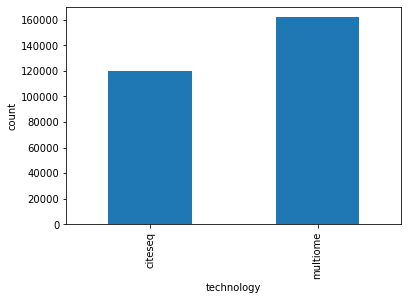

In [49]:
metadata_df.technology.value_counts().sort_index().plot(kind='bar',xlabel='technology',ylabel='count')

In [22]:
metadata_df

,day,donor,cell_type,technology
cell_id,,,,
c2150f55becb,2,27678,HSC,citeseq
65b7edf8a4da,2,27678,HSC,citeseq
c1b26cb1057b,2,27678,EryP,citeseq
917168fa6f83,2,27678,NeuP,citeseq
2b29feeca86d,2,27678,EryP,citeseq
...,...,...,...,...
96a60b026659,10,31800,hidden,multiome
d493e546991e,10,31800,hidden,multiome
05666c99aa48,10,31800,hidden,multiome


In [4]:
metadata_df = pd.read_csv(FP_CELL_METADATA, index_col = 'cell_id')
metadata_df = metadata_df[metadata_df.technology == "citeseq"]

# Read train and convert to sparse matrix
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)
cell_index = X.index
meta = metadata_df.reindex(cell_index)
X0 = X[important_cols].values

#del X
gc.collect()


# Read test and convert to sparse matrix
Xt = pd.read_hdf(FP_CITE_TEST_INPUTS).drop(columns = constant_cols)
cell_index_test = Xt.index
meta_test = metadata_df.reindex(cell_index_test)
X0t = Xt[important_cols].values

#del Xt
gc.collect()

st = StandardScaler()
X0 = st.fit_transform(X0)
X0t = st.transform(X0t)

print(f'X0 shape {X0.shape} X0t shape {X0t.shape}')

X0 shape (70988, 84) X0t shape (48663, 84)


## Upload train/test files already reduced (TruncatedSVD)

In [9]:
length = int((len(X) + len(Xt))/2)
svd = TruncatedSVD(n_components = 512,random_state = 1)
svd.fit(X[:length])
X = svd.transform(X)

In [ ]:
with open('../../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

## Target normalization

In [ ]:
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

## Let's keep only some features

In [ ]:
X = np.hstack((X[:,:75],X0))
X.shape

## Tensorflow Keras librairies

In [4]:
!pip install --upgrade --force-reinstall tensorflow

  Using cached tensorflow-2.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.1 MB)
  Using cached setuptools-65.5.0-py3-none-any.whl (1.2 MB)
  Using cached grpcio-1.50.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached h5py-3.7.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.5 MB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached wrapt-1.14.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.many

In [36]:
also_important = np.genfromtxt('../sparse/also_important.csv',delimiter=',').astype(int)
also_important

array([16257, 16136, 16011,  8589, 16270, 16023, 14871, 16028, 16158,
        6176, 16291, 15908, 16165, 16036, 15918, 15920,  9649,  9651,
       16055, 15929, 16185, 16188, 16061, 16192,  7881, 16201, 16205,
       16079, 15953, 15958, 17622, 16218, 12512, 12514, 12515, 12516,
       18917, 16103, 12520, 12521, 12525, 12526, 16243, 11764, 16126])

In [5]:
import math
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization

2022-11-03 03:03:57.033210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 03:03:57.170300: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-03 03:03:57.208396: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 03:03:57.792760: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Metric and loss function

In [6]:
def correlation_score(y_true, y_pred):
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(y_true.shape[0]):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, tf.shape(y_true)[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(tf.shape(y_true)[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

## Model and parameters

In [7]:
LR_START = 0.01
BATCH_SIZE = 512

def create_model():
    
    reg1 = 8e-5
    reg2 = 2e-5
    # reg1 = 9.613e-06
    # reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(X.shape[1],))

    x0 = Dense(256, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(Y.shape[1],
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    model = Model(inputs, x)
    

    return model

## Training

In [29]:
after_ratio

MasP    0.249190
NeuP    0.200246
HSC     0.188075
EryP    0.173075
MkP     0.148025
MoP     0.037704
BP      0.003685
Name: cell_type, dtype: float64

In [13]:
after_counts

MasP    39588
NeuP    31812
HSC     29879
EryP    27496
MkP     23516
MoP      5989
BP        585
Name: cell_type, dtype: int64

In [35]:
after_counts.sum()

158865

In [34]:
meta.cell_type.value_counts()

HSC     29879
EryP    14241
NeuP    12493
MasP     8242
MkP      5382
MoP       591
BP        160
Name: cell_type, dtype: int64

In [36]:
meta.cell_type.value_counts().sum()

70988

In [12]:
after_ratio = meta_test.loc[meta_test.day == 7].cell_type.value_counts()/meta_test.loc[meta_test.day == 7].count()[0]
after_counts = (after_ratio/after_ratio['HSC']*meta.loc[meta.cell_type=='HSC'].count()[0]).astype(int)

In [43]:
meta.cell_type.value_counts()

HSC     29879
EryP    14241
NeuP    12493
MasP     8242
MkP      5382
MoP       591
BP        160
Name: cell_type, dtype: int64

In [44]:
after_counts

{'MasP': 39588,
 'NeuP': 31812,
 'HSC': 29879,
 'EryP': 27496,
 'MkP': 23516,
 'MoP': 5989,
 'BP': 585}

In [48]:
pd.DataFrame(meta.cell_type.value_counts())

,cell_type
HSC,29879
EryP,14241
NeuP,12493
MasP,8242
MkP,5382
MoP,591
BP,160


In [50]:
after_counts

{'MasP': 39588,
 'NeuP': 31812,
 'HSC': 29879,
 'EryP': 27496,
 'MkP': 23516,
 'MoP': 5989,
 'BP': 585}

In [13]:
after_counts = after_counts.to_dict()

In [20]:
weights = meta.apply(lambda x:after_counts[x.cell_type],axis=1)

In [35]:
abc = pd.DataFrame(X).join(pd.DataFrame(Y),rsuffix='r').sample(n =158865, replace = True, weights = weights.values).to_numpy()
Y = abc[:,-140:]
X = abc[:,:-140]
del abc
X.shape

(158865, 159)

In [23]:
weights

cell_id
45006fe3e4c8    26739
d02759a80ba2    26739
dtype: int64

In [29]:
def data_generator(X,Y,weights,batch_size):
    while True:
        abc = pd.DataFrame(X).join(pd.DataFrame(Y),rsuffix='r').sample(n=158865, replace = True, weights = weights.values).to_numpy()
        Y_abc = abc[:,-140:]
        X_abc = abc[:,:-140]
        i = batch_size
        while i < len(Y):
            yield X_abc[i-batch_size:i],Y_abc[i-batch_size:i]
            i += batch_size

In [36]:
Y.shape

(158865, 140)

In [72]:
tf.shape(X)[1]

<tf.Tensor: shape=(), dtype=int32, numpy=159>

In [27]:
after_counts

MasP    35427
NeuP    28469
HSC     26739
EryP    24606
MkP     21045
MoP      5360
BP        523
Name: cell_type, dtype: int64

In [28]:
%%time
import warnings
import math
warnings.filterwarnings("ignore")

EPOCHS = 300 
N_SPLITS = 10

pred_train = np.zeros((Y.shape[0],Y.shape[1]))

np.random.seed(1)
tf.random.set_seed(1)
score_list = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=N_SPLITS)
score_list = []

after_ratio = meta_test.loc[meta_test.day == 7].cell_type.value_counts()/meta_test.loc[meta_test.day == 7].count()[0]

for fold, (idx_tr, idx_va) in enumerate(kf.split(X)):
    if fold == 4:
        break
    start_time = datetime.datetime.now()
    model = None
    gc.collect()
    
    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]
    X_va = X[idx_va]
    y_va = Y[idx_va]
    
    after_counts = (after_ratio/after_ratio['HSC']*meta.iloc[idx_tr].loc[meta.cell_type=='HSC'].count()[0]).astype(int)
    after_counts = after_counts / after_counts.sum()
    weights = meta.iloc[idx_tr].apply(lambda x:after_counts[x.cell_type],axis=1)

    lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)

    es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 40, 
                    verbose = VERBOSE,
                    mode = "min", 
                    restore_best_weights = True)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './citeseq',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)

    callbacks = [
                    lr, 
                    es, 
                    model_checkpoint_callback
                    ]
    
    model = create_model()
    
    model.compile(
                optimizer = tf.keras.optimizers.Adam(learning_rate=LR_START),
                metrics = [negative_correlation_loss],
                loss = negative_correlation_loss
                 )
    # Training
    model.fit_generator(
                data_generator(X_tr,y_tr,weights,BATCH_SIZE), 
                steps_per_epoch = len(Y)//BATCH_SIZE,
                validation_data=(
                                X_va,
                                y_va), 
                epochs = EPOCHS,
                verbose = VERBOSE,
                shuffle = True,
                callbacks = callbacks)

    del X_tr, y_tr 
    gc.collect()
    
    model.load_weights('./citeseq')
    model.save(f"./submissions/cite_weighted_model_{fold}")
    print('model saved')
    
    #  Model validation
    y_va_pred = model.predict(X_va)
    corrscore = correlation_score(y_va, y_va_pred)
    pred_train[idx_va] = y_va_pred
    
    print(f"Fold {fold}, correlation =  {corrscore:.5f}")
    del X_va, y_va, y_va_pred
    gc.collect()
    score_list.append(corrscore)

# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")
score_total = correlation_score(Y, pred_train)
print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

cell_id
5dacbb57bc56    0.173076
648e2b73a69d    0.188078
efc0d28eba0a    0.188078
c9fe8cf4852d    0.188078
53c45425b188    0.188078
                  ...   
650ee456f0f3    0.188078
cc506e7707f5    0.173076
a91f1b55a520    0.173076
3a9882c98205    0.249192
c91b6b2ccd3d    0.173076
Length: 63889, dtype: float64
model saved
222/222 [==============================] - 0s 2ms/step
Fold 0, correlation =  0.89770
cell_id
45006fe3e4c8    0.188079
d02759a80ba2    0.188079
c016c6b0efa5    0.173076
ba7f733a4f75    0.200248
fbcf2443ffb2    0.173076
                  ...   
650ee456f0f3    0.188079
cc506e7707f5    0.173076
a91f1b55a520    0.173076
3a9882c98205    0.249189
c91b6b2ccd3d    0.173076
Length: 63889, dtype: float64


KeyboardInterrupt: 

## CITEseq Test prediction

In [22]:
Xt = np.hstack((Xt[:,:75],X0t))
Xt.shape

(48663, 159)

In [24]:
test_pred = np.zeros((len(Xt), 140), dtype=np.float32)
for fold in range(4):
    print(f"Predicting with fold {fold}")
    model = load_model(f"./submissions/model_{fold}",
                       custom_objects={'negative_correlation_loss': negative_correlation_loss})
    test_pred += model.predict(Xt)

# # Copy the targets for the data leak but useless since the change in the public LB...
test_pred[:7476] = Y[:7476]

# from Juan Smith Perera to complete with the Multiome part :
submission = pd.read_csv('../submission.csv',index_col='row_id', squeeze=True)
submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
assert not submission.isna().any()

submission.to_csv('submission_lolo_1.csv')
display(submission)

row_id
0           0.094605
1          -0.162362
2          -0.405332
3          -0.302582
4           1.114355
              ...   
65744175    5.422715
65744176   -0.302524
65744177   -0.293852
65744178    0.755234
65744179    4.725446
Name: target, Length: 65744180, dtype: float64

## ------ Multiome MODEL ---------

## Upload of the multiome files after TruncatedSVD

In [37]:
pca_both = np.genfromtxt('../multi_pca/inputs_both_128.csv',delimiter=',')

KeyboardInterrupt: 

In [4]:
pca_both.shape

(161877, 128)

In [18]:
metadata_df

NameError: name 'metadata_df' is not defined

In [15]:
X = scipy.sparse.load_npz("../sparse/train_multi_inputs_values.sparse.npz")
Xt = scipy.sparse.load_npz("../sparse/test_multi_inputs_values.sparse.npz")
svd = TruncatedSVD(n_components = 512,random_state = 1)
X = svd.fit_transform(X)
Xt = svd.transform(Xt)
np.savetxt('../multi_pca/multi_train_inputs_512.csv',X,delimiter=',')
np.savetxt('../multi_pca/multi_test_inputs_512.csv',Xt,delimiter=',')

In [17]:
Xt.shape

(55935, 512)

In [6]:
Y.shape

(105942, 23418)

In [ ]:
Y = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
svd = TruncatedSVD(n_components = 1024,random_state = 1)
Y = svd.fit_transform(Y)
np.savetxt('../multi_pca/multi_pca_target_1024.csv',Y,delimiter=',')

In [ ]:
Y = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
svd = TruncatedSVD(n_components = 1024,random_state = 1)
Y = svd.fit_transform(Y)

In [72]:
svd = TruncatedSVD(n_components = 1024,random_state = 1)
Y_pca = svd.fit_transform(Y)

In [82]:
Y = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
svd = TruncatedSVD(n_components = 4096,random_state = 1)
Y = svd.fit_transform(Y)
np.savetxt('../multi_pca/multi_pca_target_4096.csv',Y,delimiter=',')
np.savetxt('../multi_pca/multi_pca_target_4096_expl_var_ratio.csv',svd.explained_variance_ratio_,delimiter=',')
print(svd.explained_variance_ratio_)
np.savetxt('../multi_pca/multi_pca_target_4096_comps.csv',svd.components_,delimiter=',')

[2.78131161e-02 1.57003384e-02 1.04928175e-02 ... 7.89676706e-05
 7.88748948e-05 7.88756952e-05]


In [85]:
len(np.genfromtxt('../multi_pca/multi_pca_target_4096_expl_var_ratio.csv',delimiter=','))

4096

Text(0, 0.5, 'explained variance')

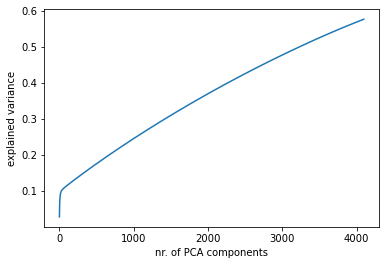

In [112]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('nr. of PCA components')
plt.ylabel('explained variance')

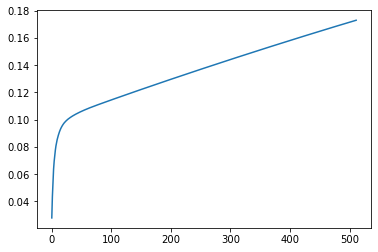

In [81]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))

In [76]:
Y = np.genfromtxt('../multi_pca/multi_pca_target_1024.csv',delimiter=',')
Y.shape

(105942, 1024)

In [73]:
np.savetxt('../multi_pca/multi_pca_target_1024.csv',Y_pca,delimiter=',')

In [11]:
X = pca_both[:105942]
Xt = pca_both[105942:]
np.savetxt('../multi_pca/pca_train_inputs_128.csv',X,delimiter=',')
np.savetxt('../multi_pca/pca_test_inputs_128.csv',Xt,delimiter=',')

In [38]:
Y_pca = np.genfromtxt('../multi_pca/pca_target_128.csv',delimiter=',')

In [39]:
X = np.genfromtxt('../multi_pca/pca_train_inputs_128.csv',delimiter=',')
Xt = np.genfromtxt('../multi_pca/pca_test_inputs_128.csv',delimiter=',')

In [54]:
cell_index = np.load("../sparse/train_multi_inputs_idxcol.npz",
                   allow_pickle=True)["index"]

In [71]:
y_columns = np.load("../sparse/train_multi_targets_idxcol.npz",
                   allow_pickle=True)["columns"]

In [72]:
y_columns.shape

(23418,)

In [68]:
Y = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(Y)
np.savetxt('../multi_pca/multi_pca_target_512.csv',Y,delimiter=',')
np.savetxt('../multi_pca/multi_pca_target_512_expl_var_ratio.csv',svd.explained_variance_ratio_,delimiter=',')
print(svd.explained_variance_ratio_)
np.savetxt('../multi_pca/multi_pca_target_512_comps.csv',svd.components_,delimiter=',')

[0.0278128  0.01570018 0.01049273 0.00962282 0.00585145 0.00427415
 0.00390518 0.00311588 0.00229792 0.00219435 0.00175172 0.00151939
 0.00139337 0.00131166 0.00109559 0.00105377 0.00087686 0.00081732
 0.00074954 0.00066443 0.0006069  0.00057276 0.00048886 0.00047038
 0.00044206 0.00042209 0.00040114 0.00036731 0.00034169 0.00032389
 0.00032309 0.0003028  0.00030065 0.00028802 0.00028376 0.00026684
 0.00026323 0.00025674 0.00024855 0.00024403 0.00023537 0.00023275
 0.0002281  0.0002267  0.00022356 0.00021854 0.00021366 0.00021028
 0.00020919 0.00020512 0.00020212 0.00020032 0.00019539 0.0001934
 0.0001919  0.00018993 0.0001891  0.00018733 0.00018444 0.00018128
 0.00017991 0.00017842 0.00017608 0.00017436 0.00017277 0.00017049
 0.00017013 0.00016872 0.00016698 0.00016683 0.00016521 0.00016432
 0.00016367 0.00016276 0.00016219 0.00016191 0.00016113 0.00016098
 0.00016086 0.00016009 0.00015999 0.00015933 0.00015915 0.0001584
 0.00015828 0.0001581  0.00015792 0.00015768 0.00015758 0.000157

In [73]:
X.shape

(105942, 512)

In [67]:
x_columns = np.load("../sparse/train_multi_inputs_idxcol.npz",
                   allow_pickle=True)["columns"]

In [63]:
y_columns[:15]

array(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33'],
      dtype=object)

In [70]:
len(y_columns)

140

In [53]:
y_columns

array(['ENSG00000121410', 'ENSG00000268895', 'ENSG00000175899', ...,
       'ENSG00000162378', 'ENSG00000159840', 'ENSG00000074755'],
      dtype=object)

In [21]:
y_columns.shape

(23418,)

In [20]:
x_columns.shape

(22050,)

In [48]:
import re
xx = 'ENSG00000121410_A1BG'
r1 = re.split(r"_",'ENSG00000121410_A1BG')
print(r1)

['ENSG00000121410', 'A1BG']


In [44]:
x_columns[0]

'ENSG00000121410_A1BG'

In [46]:
re.splitr"_",'ENSG00000121410_A1BG']

TypeError: 'function' object is not subscriptable

In [50]:
import re
x_columns_trim = [re.split(r"_",i)[0] for i in x_columns]

In [51]:
len(set(x_columns_trim))

22050

In [52]:
len(set(y_columns))

23418

In [54]:
len(set(x_columns_trim) - set(y_columns))

3664

In [55]:
len(set(y_columns) - set(x_columns_trim))

5032

In [56]:
missing_cols = list(set(x_columns_trim) - set(y_columns))

In [25]:
with open('../../input/targets-multiome-sparse-scaled/INDEX_train_multiome.pkl','rb') as f: INDEX_train_multiome = pickle.load(f)
with open('../../input/targets-multiome-sparse-scaled/train_512.pkl','rb') as f: X = pickle.load(f)
with open('../../input/targets-multiome-sparse-scaled/pca_train_512.pkl','rb') as f: pca_train = pickle.load(f)
with open('../../input/targets-multiome-sparse-scaled/pca_target_512.pkl','rb') as f: pca_target = pickle.load(f)
with open('../../input/targets-multiome-sparse-scaled/Y_512.pkl','rb') as f: Y = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../../input/targets-multiome-sparse-scaled/INDEX_train_multiome.pkl'

In [42]:
X = X[:,:40]
X.shape

(105942, 40)

In [103]:
metadata_df.groupby("day").count()

,donor,cell_type,technology
day,,,
2,32832,32832,32832
3,36765,36765,36765
4,31134,31134,31134
7,29373,29373,29373
10,31773,31773,31773


In [100]:
len(Xt)

55935

In [99]:
len(Y)

105942

In [98]:
len(metadata_df)

161877

In [55]:
INDEX_train_multiome = cell_index

In [19]:
metadata_df = pd.read_csv('../../input/open-problems-multimodal/metadata.csv',index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(INDEX_train_multiome)

NameError: name 'INDEX_train_multiome' is not defined

In [120]:
Y = Y_pca

In [121]:
Y.shape, X.shape

((105942, 1024), (105942, 40))

## Training for Multiome

In [106]:
metadata_df.groupby(['day','cell_type']).donor.count().unstack()

cell_type,BP,EryP,HSC,MasP,MkP,MoP,NeuP,hidden
day,,,,,,,,
2,262.0,3402.0,10757.0,2175.0,3394.0,258.0,3663.0,8921.0
3,121.0,4699.0,11167.0,3549.0,2886.0,498.0,5895.0,7950.0
4,123.0,6054.0,9116.0,5228.0,3495.0,462.0,6656.0,NaN
7,60.0,2980.0,3621.0,5785.0,3446.0,843.0,5347.0,7291.0
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31773.0


In [90]:
meta.groupby(['day','cell_type']).donor.count().unstack()

cell_type,BP,EryP,HSC,MasP,MkP,MoP,NeuP
day,,,,,,,
2,262,3402,10757,2175,3394,258,3663
3,121,4699,11167,3549,2886,498,5895
4,123,6054,9116,5228,3495,462,6656
7,60,2980,3621,5785,3446,843,5347


<AxesSubplot:xlabel='day'>

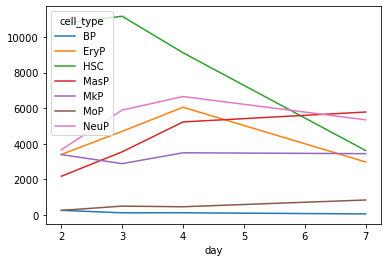

In [91]:
meta.groupby(['day','cell_type']).donor.count().unstack().plot()

In [96]:
abc = meta.groupby(['day','cell_type']).donor.count().unstack()
2*abc.loc[7]-abc.loc[4]

cell_type
BP        -3
EryP     -94
HSC    -1874
MasP    6342
MkP     3397
MoP     1224
NeuP    4038
dtype: int64

BP - ignore
EryP - day 7 levels
HSC - only 500
MasP - day 7 levels
MkP - day 7 levels
MoP - 1200
NeuP - day 7 levels


In [110]:
meta.loc[meta.day == 7].groupby(['cell_type']).donor.count()

cell_type
BP        60
EryP    2980
HSC     3621
MasP    5785
MkP     3446
MoP      843
NeuP    5347
Name: donor, dtype: int64

In [112]:
abc = meta.loc[meta.day == 7].groupby(['cell_type']).donor.count()
abc.HSC = 500
abc.MoP = 1200
after_ratio = abc/abc.sum()

cell_type
BP      0.003106
EryP    0.154260
HSC     0.025883
MasP    0.299462
MkP     0.178383
MoP     0.062118
NeuP    0.276788
Name: donor, dtype: float64

In [118]:
meta.groupby(['cell_type']).donor.count()

cell_type
BP        566
EryP    17135
HSC     34661
MasP    16737
MkP     13221
MoP      2061
NeuP    21561
Name: donor, dtype: int64

In [116]:
abc

cell_type
BP        60
EryP    2980
HSC      500
MasP    5785
MkP     3446
MoP     1200
NeuP    5347
Name: donor, dtype: int64

In [119]:
meta.groupby(['cell_type']).donor.count()/abc

cell_type
BP       9.433333
EryP     5.750000
HSC     69.322000
MasP     2.893172
MkP      3.836622
MoP      1.717500
NeuP     4.032355
Name: donor, dtype: float64

In [115]:
(after_ratio/after_ratio['HSC']*meta.loc[meta.cell_type=='HSC'].count()[0]).astype(int).sum()


184292

In [53]:
Y_true = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
Y_true = Y_true.toarray()
Y = np.genfromtxt('../multi_pca/pca_target_128.csv',delimiter=',')
pca_target_comps = np.genfromtxt('../multi_pca/multi_pca_target_512_comps.csv',delimiter=',')
pca_target_comps = pca_target_comps[:128]
metadata_df = pd.read_csv('../../input/open-problems-multimodal/metadata.csv',index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
cell_index = np.load("../sparse/train_multi_inputs_idxcol.npz",
                   allow_pickle=True)["index"]
meta = metadata_df.reindex(cell_index)
X = np.genfromtxt('../multi_pca/multi_train_inputs_512.csv',delimiter=',')
Xt = np.genfromtxt('../multi_pca/multi_test_inputs_512.csv',delimiter=',')

In [79]:
np.savetxt('../multi_pca/tenth/Y.csv',Y[:int(len(Y)/10)],delimiter=',')

In [58]:
Y_true = Y_true[:int(len(X)/10)]
meta = meta[:int(len(X)/10)]
Y = Y[:int(len(X)/10)]
X = X[:int(len(X)/10)]
np.savetxt('../multi_pca/tenth/Y.csv',Y,delimiter=',')
np.savetxt('../multi_pca/tenth/X.csv',X,delimiter=',')
np.savetxt('../multi_pca/tenth/Y_true.csv',Y_true,delimiter=',')

TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e,%.18e,%.18e,%.18e')

In [124]:
Y = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
#Y = Y[:int(Y.shape[0]/10)]
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(Y)
np.savetxt('../multi_pca/multi_pca_target_512.csv',Y,delimiter=',')
np.savetxt('../multi_pca/multi_pca_target_512_expl_var_ratio.csv',svd.explained_variance_ratio_,delimiter=',')
print(svd.explained_variance_ratio_)
np.savetxt('../multi_pca/multi_pca_target_512_comps.csv',svd.components_,delimiter=',')

[0.00695985 0.01673152 0.01090715 0.00969896 0.00598933 0.00421402
 0.00407032 0.00314911 0.00233622 0.00222157 0.00175635 0.00150151
 0.00138537 0.00131442 0.00110326 0.00107351 0.00087716 0.00082342
 0.00076914 0.00068163 0.00061428 0.00057314 0.00050048 0.00048944
 0.00046858 0.00043102 0.00039843 0.00037335 0.00035114 0.00033391
 0.00032945 0.00031116 0.00030863 0.00029754 0.00029456 0.00027571
 0.00027214 0.00026426 0.00025694 0.00025296 0.00024327 0.00023901
 0.00023524 0.00023322 0.00023166 0.00022525 0.00021981 0.00021628
 0.0002135  0.00021062 0.00020927 0.00020644 0.00020216 0.0001989
 0.00019782 0.00019606 0.00019474 0.00019226 0.00019192 0.00018824
 0.00018537 0.00018384 0.0001829  0.00018021 0.00017824 0.00017595
 0.00017494 0.0001746  0.00017291 0.00017205 0.00017079 0.00016987
 0.00016921 0.0001684  0.00016781 0.00016698 0.0001661  0.00016619
 0.00016592 0.00016576 0.00016508 0.00016484 0.00016439 0.00016388
 0.00016336 0.00016337 0.00016325 0.00016318 0.00016299 0.00016

In [72]:
Y = np.genfromtxt('../multi_pca/tenth/Y.csv',delimiter=',')
X = np.genfromtxt('../multi_pca/tenth/X.csv',delimiter=',')
pca_target_comps = np.genfromtxt('../multi_pca/multi_pca_target_512_comps.csv',delimiter=',')
Y_true = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
Y_true = Y_true.toarray()
metadata_df = pd.read_csv('../../input/open-problems-multimodal/metadata.csv',index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
cell_index = np.load("../sparse/train_multi_inputs_idxcol.npz",
                   allow_pickle=True)["index"]
meta = metadata_df.reindex(cell_index)
meta = meta[:int(len(Y_true)/10)]
Y_true = Y_true[:int(len(Y_true)/10)]

In [144]:
import warnings
warnings.filterwarnings("ignore")

Y = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
Y = scprep.filter.remove_empty_genes(Y)
Y = Y[:int(Y.shape[0]/10)]
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(Y)

X = np.genfromtxt('../multi_pca/tenth/X.csv',delimiter=',')
X -= X.mean(axis=1).reshape(-1, 1)
X /= X.std(axis=1).reshape(-1, 1)
X = X[:,:64]

pred_train = np.zeros_like(Y)

N_SPLIT = 3
#kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
kf = KFold(n_splits = N_SPLIT)

abc = meta.loc[meta.day == 7].groupby(['cell_type']).donor.count()
abc.HSC = 500
abc.MoP = 1200
after_ratio = abc/abc.sum()
score_list = []

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):
    
    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]
    
    X_va = X[idx_va]
    y_va = Y[idx_va]
    
    #day = (meta.iloc[idx_va].iloc[0]).day
    
    model = create_model()
    
    #weights = meta.iloc[idx_tr].apply(lambda x:after_ratio[x.cell_type],axis=1)    
    
    lr = ReduceLROnPlateau(
                monitor = "val_loss",
                factor = 0.9, 
                patience = 4, 
                verbose = VERBOSE)
    
    es = EarlyStopping(
                monitor = "val_loss",
                patience = 30, 
                verbose = VERBOSE,
                mode = "min", 
                restore_best_weights = True)

    model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
            metrics = [negative_correlation_loss],
            loss = negative_correlation_loss
             )

    model.fit(X_tr,
              y_tr,
              validation_data=(X_va,y_va),
              epochs =500,
              verbose = VERBOSE,
              batch_size=256,
              callbacks = [es,lr]
             )
    y_va_pred = model.predict(X_va)
    
    print(f'\n --------- FOLD {fold} -----------')
    
    corrscore = correlation_score(y_va, y_va_pred)
    pred_train[idx_va] = y_va_pred
    
    print(f"Day {day}, correlation =  {corrscore:.5f}")
   
    model.save(f"./submissions/multi_model_{fold}")

    print('model saved')
        
    del X_tr,X_va,y_tr,y_va
    gc.collect()
    score_list.append(corrscore)
    
# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")
score_total = correlation_score(Y_true, svd.inverse_transform(pred_train))#pred_train@pca_target_comps)
print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

111/111 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Day 2, correlation =  0.91610
INFO:tensorflow:Assets written to: ./submissions/multi_model_0/assets
model saved
111/111 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Day 2, correlation =  0.91447
INFO:tensorflow:Assets written to: ./submissions/multi_model_1/assets
model saved
111/111 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Day 2, correlation =  0.88766
INFO:tensorflow:Assets written to: ./submissions/multi_model_2/assets
model saved
Mean corr = 0.90608
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/srv/conda/envs/saturn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_788/2405836986.py", line 89, in <cell line: 89>
    score_total = correlation_score(Y_true, svd.inverse_transform(pred_train))#pred_train@pca_target_comps)
  File "/tmp/ipykernel_788/3197265398.py", line 6, in correlation_score
    corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
  File "<__array_function__ internals>", line 5, in corrcoef
  File "/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py", line 2683, in corrcoef
    # Determine the normalization
  File "<__array_function__ internals>", line 5, in cov
  File "/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py", line 2477, in cov
  File "<__array_function__ internals>", line 5, in concatenate
ValueError: all the input array dimensions for the conca

In [155]:
Y_true.shape

(105942, 22858)

In [157]:
Y_true.shape

(10594, 22858)

In [158]:
svd.inverse_transform(pred_train).shape

(10594, 22858)

In [160]:
# Y_true = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
# Y_true = scprep.filter.remove_empty_genes(Y_true)
#Y_true = Y_true[:int(Y_true.shape[0]/10)]
Y_true = Y_true.toarray()

score_total = correlation_score(Y_true, svd.inverse_transform(pred_train))#pred_train@pca_target_comps)


In [161]:
score_total

0.6037593737090287

X:512, Y:512, corr = 0.555
X:512, Y:128, corr = 0.544
X:128, Y:512, corr = 0.568
X:64,  Y:512, corr = 0.592

X:64, Y:512, corr = 0.576/0.555
X norm, Y norm -> corr = 0.607

Text(0, 0.5, 'Correlation')

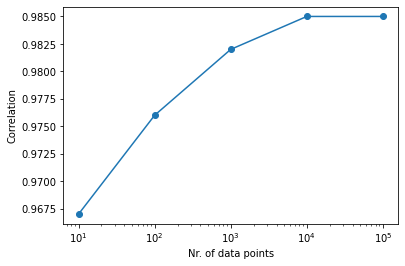

In [67]:
plt.scatter([10,100,1000,10000,100000],[0.967,0.976,0.982,0.985,0.985])
plt.plot([10,100,1000,10000,100000],[0.967,0.976,0.982,0.985,0.985])
#plt.plot([10,100,1000,10000,100000],[0.579,0.560,0.524,0.568,0.568])
plt.xscale('log')
plt.xlabel('Nr. of data points')
plt.ylabel('Correlation')

In [143]:
targets.shape

(105942, 23418)

In [142]:
import scprep
scprep.filter.remove_empty_genes(targets).shape

(105942, 7514)

In [38]:
def delete_columns_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    mask = np.ones(mat.shape[1], dtype=bool)
    mask[indices] = False
    return mat[:,mask]

def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def correlation_score_cols(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    abc = []
    for i in range(y_true.shape[1]):
        temp = np.corrcoef(y_true[:,i], y_pred[:,i])[1, 0]
        abc.append(temp)
        corrsum += temp
    print(corrsum / y_true.shape[1])
    return abc

def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, y_true.shape[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(y_true.shape[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

def negative_pearson_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """

    vx = y_pred - torch.mean(y_pred,1,keepdim=True)
    vy = y_true - torch.mean(y_true,1,keepdim=True)

    cost = torch.mean(torch.sum(vx * vy,1) / (torch.sqrt(torch.sum(vx ** 2,1)) * torch.sqrt(torch.sum(vy ** 2,1))))

    return - cost

def create_model():
    
    reg1 = 8e-5
    reg2 = 2e-5
    # reg1 = 9.613e-06
    # reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(X.shape[1],))

    x0 = Dense(256, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(Y.shape[1],
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    model = Model(inputs, x)
    
    return model

def my_model(n_inputs,n_outputs, reg1, reg2,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'
    DROP = 0.1
    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)

    x1 = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x0)
    x0 = Dropout(DROP)(x0)

    x2 = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x1)
    x0 = Dropout(DROP)(x0)

    x3 = Dense(Y.shape[1],
           kernel_regularizer = tf.keras.regularizers.l2(reg2),
            activation='linear',
         )(x2)
    x3 = Dropout(DROP)(x3)

    x = Concatenate()([x0, x1, x2, x3])
    x = Dense(n_outputs, kernel_regularizer=tf.keras.regularizers.l2(reg2),
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

# Cross-validation
VERBOSE = 2 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 3

def fit(X_train, y_train,meta,loss=negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                              patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                          patience=12, 
                          verbose=0,
                          mode="min", 
                          restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

        # Construct and compile the model
        model = my_model(n_inputs=X_train.shape[1],n_outputs=y_train.shape[1],reg1=reg1,reg2=reg2,loss = loss)

        # Train the model
        history = model.fit(X_tr, y_tr, 
                            validation_data=(X_va, y_va), 
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=callbacks)
        del X_tr, y_tr

        # We validate the model
        y_pred = model.predict(X_va, batch_size=X_va.shape[0])
        corrscore = correlation_score(y_va, y_pred)

        print(f"Fold {fold}: {es.stopped_epoch:3} epochs, corr =  {corrscore:.5f}")
        del es, X_va#, y_va, y_va_pred
        score_list.append(corrscore)

        return model

    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")
    
inputs_both_128 = np.genfromtxt("../multi_pca/inputs_both_128.csv", delimiter=',')
multi_X_train = inputs_both_128[:105942]
targets = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
import scprep
targets = scprep.filter.remove_empty_genes(targets)
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets = scprep.filter.remove_empty_genes(targets)
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)

pca_train = TruncatedSVD(n_components=128, random_state=1)
pca_targets = pca_train.fit_transform(targets)

with np.load('../sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']

with np.load('../sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']

metadata_df = pd.read_csv('../../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)

LR_START = 0.01
BATCH_SIZE = 256
reg1 = 8e-5
reg2 = 2e-5
X = multi_X_train
Y = pca_targets
model = fit(multi_X_train,pca_targets,meta)

In [19]:
pca_train.inverse_transform(y_va_pred).shape

(35314, 22858)

In [20]:
y_va.shape

(35314, 128)

In [22]:
correlation_score(targets[idx_va], pca_train.inverse_transform(y_va_pred))

0.655704902055328

In [32]:
X.shape

(10594, 128)

In [33]:
Y.shape

(10594, 128)

In [26]:
X = X[:int(len(X)/10)]
Y = Y[:int(len(Y)/10)]
meta = meta[:int(len(meta)/10)]

In [39]:
import warnings
warnings.filterwarnings("ignore")
VERBOSE = 0

pred_train = np.zeros_like(Y)

N_SPLIT = 3
#kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
kf = KFold(n_splits = N_SPLIT)

score_list = []

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):
    
    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]
    
    X_va = X[idx_va]
    y_va = Y[idx_va]
    
    #day = (meta.iloc[idx_va].iloc[0]).day
    
    #model = my_model(n_inputs=X.shape[1],n_outputs=Y.shape[1],reg1=reg1,reg2=reg2,loss = negative_correlation_loss)
    model = create_model()
    #weights = meta.iloc[idx_tr].apply(lambda x:after_ratio[x.cell_type],axis=1)    
    
    lr = ReduceLROnPlateau(
                monitor = "val_loss",
                factor = 0.9, 
                patience = 4, 
                verbose = VERBOSE)
    
    es = EarlyStopping(
                monitor = "val_loss",
                patience = 30, 
                verbose = VERBOSE,
                mode = "min", 
                restore_best_weights = True)

    model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2),
            metrics = [negative_correlation_loss],
            loss = negative_correlation_loss
             )

    model.fit(X_tr,
              y_tr,
              validation_data=(X_va,y_va),
              epochs =500,
              verbose = VERBOSE,
              batch_size=256,
              callbacks = [es,lr]
             )
    y_va_pred = model.predict(X_va)
    
    print(f'\n --------- FOLD {fold} -----------')
    
    corrscore = correlation_score(y_va, y_va_pred)
    pred_train[idx_va] = y_va_pred
    
    print(f"Day {day}, correlation =  {corrscore:.5f}")
   
    model.save(f"./submissions/multi_model_{fold}")

    print('model saved')
        
    del X_tr,X_va,y_tr,y_va
    gc.collect()
    score_list.append(corrscore)
    
# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")
score_total = correlation_score(Y_true, svd.inverse_transform(pred_train))#pred_train@pca_target_comps)
print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

1104/1104 [==============================] - 2s 2ms/step

 --------- FOLD 0 -----------


NameError: name 'day' is not defined

In [40]:
#full dataset - create_model
correlation_score(targets[idx_va], pca_train.inverse_transform(y_va_pred))

0.6630533062710808

In [37]:
#only 1/10 create_model - fixed learning rate!
correlation_score(targets[idx_va], pca_train.inverse_transform(y_va_pred))

0.6606294324080091

In [35]:
#only 1/10 create_model
correlation_score(targets[idx_va], pca_train.inverse_transform(y_va_pred))

0.6144719934598765

In [29]:
#only 1/10 my_model
correlation_score(targets[idx_va], pca_train.inverse_transform(y_va_pred))

0.6358121876166588

In [31]:
targets = targets[:int(len(targets)/10)]
correlation_score(targets[idx_va], pca_train.inverse_transform(y_va_pred))

0.6358121876166588

In [ ]:
10,100,1000,10000,100000
0.967,0.976,0.982,0.985,0.985
plt.plot[0.579,0.560,0.524,0.568,?]

In [42]:
score_total = correlation_score(Y_true, pred_train@pca_target_comps)
print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

Oof corr   = 0.56293


## Test predictions for Multiome

In [ ]:
multi_test_x = scipy.sparse.load_npz("../input/multimodal-single-cell-as-sparse-matrix/test_multi_inputs_values.sparse.npz")
multi_test_x = pca_train.transform(multi_test_x)
multi_test_x = multi_test_x[:,:40]
multi_test_x.shape

In [ ]:
preds = np.zeros((multi_test_x.shape[0], 23418), dtype='float16')

for fold in range(N_SPLIT):
    print(f'fold {fold} prediction')
    model = tf.keras.models.load_model(f"model_{fold}")
    preds += (model.predict(multi_test_x)@pca_target.components_)/N_SPLIT

    gc.collect()

In [ ]:
eval_ids = pd.read_parquet("../input/multimodal-single-cell-as-sparse-matrix/evaluation.parquet")
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

submission = pd.Series(name='target',
                       index=pd.MultiIndex.from_frame(eval_ids), 
                       dtype=np.float32)
submission

In [ ]:
y_columns = np.load("../input/multimodal-single-cell-as-sparse-matrix/train_multi_targets_idxcol.npz",
                   allow_pickle=True)["columns"]

test_index = np.load("../input/multimodal-single-cell-as-sparse-matrix/test_multi_inputs_idxcol.npz",
                    allow_pickle=True)["index"]

cell_dict = dict((k,v) for v,k in enumerate(test_index)) 
assert len(cell_dict)  == len(test_index)

gene_dict = dict((k,v) for v,k in enumerate(y_columns))
assert len(gene_dict) == len(y_columns)

eval_ids_cell_num = eval_ids.cell_id.apply(lambda x:cell_dict.get(x, -1))
eval_ids_gene_num = eval_ids.gene_id.apply(lambda x:gene_dict.get(x, -1))
valid_multi_rows = (eval_ids_gene_num !=-1) & (eval_ids_cell_num!=-1)

submission.iloc[valid_multi_rows] = preds[eval_ids_cell_num[valid_multi_rows].to_numpy(),
eval_ids_gene_num[valid_multi_rows].to_numpy()]

del eval_ids_cell_num, eval_ids_gene_num, valid_multi_rows, eval_ids, test_index, y_columns
gc.collect()

submission

## Total submission

In [ ]:
submission.reset_index(drop=True, inplace=True)
submission.index.name = 'row_id'

cite_submission = pd.read_csv("submission_lolo_1.csv")
cite_submission = cite_submission.set_index("row_id")
cite_submission = cite_submission["target"]
submission[submission.isnull()] = cite_submission[submission.isnull()]
submission
# == > score 0.812


In [ ]:
sub_ensembling = pd.read_csv('../input/5-5-msci22-ensembling-citeseq/submission.csv')
submission1 = sub_ensembling.copy()
submission1['target'] = 0.4 * submission + 0.6 * sub_ensembling['target']
submission1

In [ ]:
submission1.to_csv("submission_lolo_total_ensembling.csv", index = False)